In [ ]:
import warnings
from pathlib import Path

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from pyensembl import EnsemblRelease

from ID_mapping import map_nw_ids
from datasets import load_pdb_id_to_date
from plotting import COLOR_Y2H, COLOR_ALPHAFOLD_ROSETTAFOLD, COLOR_LIT, COLOR_I3D

In [2]:
def get_pmid_to_date_human_pairs():
    from pmid_to_dates import get_pubmed_to_date_mapping
    evid = pd.read_csv('../data/internal/Lit-24-human_evidence.tsv', sep='\t')
    get_pubmed_to_date_mapping(list(map(str, evid['pubmed_id'].unique())),
                            chunk_size=2000)


def load_pubmed_to_date_mapping():
    in_path = Path('../data/processed/pmid_dates.csv')
    df = pd.read_csv(in_path)
    if df['pmid'].duplicated().any():
        raise UserWarning("Duplicate PMIDs in pmid_to_date")
    df['PubDate_edited'] = (df['best_date']
                            .str.replace('Winter', 'Dec')
                            .str.replace('Fall', 'Sep')
                            .str.replace('Spring', 'Mar')
                            .str.replace('Summer', 'Jun')
                            .str.replace(r'(?P<one>[A-Z][a-z][a-z])-[A-Z][a-z][a-z]',
                                        lambda x: x.group('one'), regex=True)
                            .str.replace(r'(?P<one>[A-Z][a-z][a-z] [0-9]{1,2})-.*',
                                        lambda x: x.group('one'), regex=True)
                            .str.replace(r'(?P<one>[0-9]{1,2})-[0-9]{1,2}',
                                        lambda x: x.group('one'), regex=True))
    if pd.to_datetime(df['PubDate_edited'], errors='coerce').isnull().any():
        print(df.loc[pd.to_datetime(df['PubDate_edited'], errors='coerce').isnull()])
        raise UserWarning("Some dates could not be parsed even after editing")
    df['PubDate_edited'] = pd.to_datetime(df['PubDate_edited'])
    pmid_to_date = df.set_index('pmid')['PubDate_edited']
    return pmid_to_date


def load_stelzl_et_al_full_length():
    # The original tables were .pdf files. 
    # I converted them to .xlsx using Adobe Acrobat's export function.
    df = pd.read_excel('../data/processed/Stelzl_et_al_2005_PPIs_tableS3.xlsx',
                    skiprows=1,)
    clones = pd.read_excel('../data/processed/Stelzl_et_al_2005_clones_tableS2.xlsx',
                        skiprows=1)
    clones['ID'] = clones['ID'].astype(pd.Int64Dtype())
    # drop repeated header rows
    df = df.loc[df['PPI'] != 'PPI']
    # In Venkatesan et al. 2009, the subset of MDC-HI1 (Stelzl et al. 2005) with
    # full-length clones validated well.  
    full_length_clones = set(clones.loc[clones['ORF%'] == 100, 'ID'].dropna().values)
    df = df.loc[df['ID_b'].isin(full_length_clones) & 
                df['ID_p'].isin(full_length_clones), :]
    with open("../data/internal/protein_coding_genome.txt", "r") as f:
        pcg = set(f.read().splitlines())
    id_map = {g.gene_name: g.gene_id for g in EnsemblRelease(90).genes() if g.gene_id in pcg}
    hgnc = pd.read_csv('../data/external/HGNC_2025-10-22.txt', 
                       low_memory=False,
                       sep='\t')
    hgnc_old_to_new = {}
    for _i, row in hgnc.iterrows():
        if pd.isnull(row['alias_symbol']):
            continue
        for old in row['alias_symbol'].split('|'):
            if row['symbol'] in id_map:
                hgnc_old_to_new[old] = row['symbol']
    for _i, row in hgnc.iterrows():
        if pd.isnull(row['prev_symbol']):
            continue
        for old in row['prev_symbol'].split('|'):
            if row['symbol'] in id_map:
                hgnc_old_to_new[old] = row['symbol']
    hgnc_old_to_new['STAF65(gamma)'] = 'SUPT7L'
    hgnc_old_to_new['AB026190'] =  'KLHL20'
    hgnc_old_to_new['FLJ22593'] =  'SMPD3'
    hgnc_old_to_new['MGC2494'] =  'ANTKMT'
    hgnc_old_to_new['KCNA'] =  'KCNA1'


    df['hgnc_symbol_bait'] = df['Sym_b'].map(lambda x: hgnc_old_to_new.get(x, x))
    df['hgnc_symbol_prey'] = df['Sym_p'].map(lambda x: hgnc_old_to_new.get(x, x))
    df['ensembl_gene_id_bait'] = df['hgnc_symbol_bait'].map(lambda x: id_map.get(x, np.nan))
    df['ensembl_gene_id_prey'] = df['hgnc_symbol_prey'].map(lambda x: id_map.get(x, np.nan))


    df = df.dropna(subset=['ensembl_gene_id_bait', 'ensembl_gene_id_prey'])
    df['ensembl_gene_id_a'] = df[['ensembl_gene_id_bait', 'ensembl_gene_id_prey']].min(axis=1)
    df['ensembl_gene_id_b'] = df[['ensembl_gene_id_bait', 'ensembl_gene_id_prey']].max(axis=1)
    df['pair'] = df['ensembl_gene_id_a'] + '_' + df['ensembl_gene_id_b']
    df = df.drop_duplicates('pair')
    df = df.set_index('pair').loc[:, ['ensembl_gene_id_a', 'ensembl_gene_id_b']]
    df['in_Stelzl_full_length'] = True
    df['date'] = pd.to_datetime('2005-09-23')
    return df

def load_nn1_0():
    df = pd.read_csv('../data/processed/Haenig_et_al_Cell_reports_2020.csv',
                sep='\t')
    df = map_nw_ids(df, 'uniprot_ac', 'ensembl_gene_id')
    df = df.loc[:, ['ensembl_gene_id_a', 'ensembl_gene_id_b']]
    df['in_NN1.0'] = True
    df['date'] = pd.to_datetime('2020-08-18')
    return df

def load_lit_bm_24(organism, gene_id='uniprot_ac'):
    lit = pd.read_csv('../data/internal/Lit-24-human.tsv',
                       sep='\t')
    lit = lit.loc[lit['category'] == 'Lit-BM', :]
    evid = pd.read_csv('../data/internal/Lit-24-human_evidence.tsv',
                       sep='\t')

    pmid_date = load_pubmed_to_date_mapping()
    has_invalid_pmid = ((evid['pubmed_id'] > 50000000)
                    & evid['pubmed_id'].astype(str).str.startswith('8888'))
    if evid.loc[~has_invalid_pmid, "pubmed_id"].max() > pmid_date.index.max():
        warnings.warn("Pubmed ID to date mapping is too old")
    evid["pair"] = evid[f"{gene_id}_a"] + "_" + evid[f"{gene_id}_b"]
    lit["pair"] = lit[f"{gene_id}_a"] + "_" + lit[f"{gene_id}_b"]
    lit = lit.drop_duplicates("pair")
    if lit["pair"].duplicated().any():
        raise UserWarning("unexpected duplicates")
    lit = lit.set_index("pair")
    evid["date"] = evid["pubmed_id"].map(pmid_date)
    first_date = (
        evid.sort_values("date").drop_duplicates("pair").set_index("pair")["date"]
    )
    first_binary_date = (
        evid.loc[(evid["binary"] == 1), :].sort_values("date").drop_duplicates("pair").set_index("pair")["date"]
    )
    lit["date_first_pub"] = lit.index.map(first_date)
    second_date = evid.sort_values("date").groupby("pair").nth(1)["date"]
    lit["date_second_pub"] = lit.index.map(second_date)
    lit["date_first_binary_pub"] = lit.index.map(first_binary_date)
    lit["date_bm"] = lit[["date_first_binary_pub", "date_second_pub"]].max(axis=1)
    lit = lit.sort_values("date_bm")

    return lit

def load_I3D_exp_24(organism):
    i3d = pd.read_csv(
        f"../data/external/interactome3d_2024-12_{organism}_interactions.dat", sep="\t"
    )

    df = pd.read_csv(
        f"../data/external/interactome3d_2024-12_{organism}_interactions_complete.dat",
        sep="\t",
    )
    pdb_to_date = load_pdb_id_to_date(df["PDB_ID"].unique())
    df["date"] = pd.to_datetime(df["PDB_ID"].map(pdb_to_date), errors="coerce")
    i3d = pd.merge(
        i3d,
        df.groupby(["PROT1", "PROT2"])["date"].min().reset_index(),
        how="left",
        on=["PROT1", "PROT2"],
    )

    i3d = i3d.loc[i3d["TYPE"] == "Structure", :]

    return i3d

In [3]:
with open("../data/internal/protein_coding_genome.txt", "r") as f:
    pcg = set(f.read().splitlines())
lit = load_lit_bm_24('human')
lit = map_nw_ids(lit, 'uniprot_ac', 'ensembl_gene_id')
lit = lit.reset_index().rename(columns={'index': 'pair'})
lit['date'] = lit['date_bm']

i3d = load_I3D_exp_24('h_sapiens')
i3d = i3d.rename(columns={'PROT1': 'uniprot_ac_a', 'PROT2': 'uniprot_ac_b'})
i3d = map_nw_ids(i3d, 'uniprot_ac', 'ensembl_gene_id')
i3d = i3d.reset_index().rename(columns={'index': 'pair'})

hi = pd.read_csv('../data/internal/HI_union_ensembl_gene_id.tsv', 
                 sep='\t',
                 index_col=0)
hi = hi.reset_index().rename(columns={'index': 'pair'})
hi1 = hi.loc[hi['in_Rual'], :].copy()
hi1['date'] = np.datetime64('2005-09-28')
hi2 = hi.loc[hi['in_Rolland'], :].copy()
hi2['date'] = np.datetime64('2014-11-20')
hi3 = hi.loc[hi['in_HI_III'], :].copy()
hi3['date'] = np.datetime64('2020-04-08')
stelzl = load_stelzl_et_al_full_length().reset_index().rename(columns={'index': 'pair'})
nn = load_nn1_0().reset_index().rename(columns={'index': 'pair'})

comp = pd.read_csv('../output/AFRF-core_human.tsv', sep='\t', index_col=0)
comp["uniprot_ac_a"] = comp["Protein1"]
comp["uniprot_ac_b"] = comp["Protein2"]
comp = map_nw_ids(comp, 'uniprot_ac', 'ensembl_gene_id')
comp = comp.loc[comp['ensembl_gene_id_a'].isin(pcg) & 
                comp['ensembl_gene_id_b'].isin(pcg), :]
comp = comp.reset_index().rename(columns={'index': 'pair'})
comp['is_AI'] = True
comp['date'] = np.datetime64('2025-09-25')


df = pd.concat([lit.copy(),
                i3d.copy(),
                stelzl.copy(),
                hi1.copy(),
                hi2.copy(),
                hi3.copy(),
                nn.copy(),
                comp.copy(),
                ])
df = df.loc[df['ensembl_gene_id_a'].isin(pcg) 
            & df['ensembl_gene_id_b'].isin(pcg), :]
df = df.sort_values('date').drop_duplicates(subset=['pair']).set_index('pair')

/Users/lukelambourne/work/yeri_paper_figures/notebooks/ID_mapping.py:71: UserWarning: Warning: mapping between gene/protein identifiers has resulted in different pairs in the input ID being mapped to the same pair in the output ID.
You may wish to use the `agg` argument to customize the choice of which of the pair's infomation to keep or how to combine the information from multiple pairs.
  warnings.warn('Warning: mapping between gene/protein identifiers has '
/Users/lukelambourne/work/yeri_paper_figures/notebooks/ID_mapping.py:71: UserWarning: Warning: mapping between gene/protein identifiers has resulted in different pairs in the input ID being mapped to the same pair in the output ID.
You may wish to use the `agg` argument to customize the choice of which of the pair's infomation to keep or how to combine the information from multiple pairs.
  warnings.warn('Warning: mapping between gene/protein identifiers has '
/Users/lukelambourne/work/yeri_paper_figures/notebooks/ID_mapping.py:7

In [ ]:
def assign_colors(row):
    if pd.notnull(row['n_evidence']):
        return COLOR_LIT
    elif row['TYPE'] == 'Structure':
        return COLOR_I3D
    elif (row['in_Stelzl_full_length'] == True) | pd.notnull(row['in_Rual']) | (row['in_NN1.0'] == True):
        return COLOR_Y2H
    elif row['is_AI'] == True:
        return COLOR_ALPHAFOLD_ROSETTAFOLD
    else:
        raise UserWarning("Some PPIs have no color assigned")

df['color'] = df.apply(assign_colors, axis=1)
if df['color'].isnull().any():
    raise UserWarning("Some PPIs have no color assigned")

In [5]:
# TODO: fix lazy code duplication
stezl_date = np.datetime64('2005-09-23')
rual_date = np.datetime64('2005-09-28')
rolland_date = np.datetime64('2014-11-20')
luck_date = np.datetime64('2020-04-08')
nn_date = np.datetime64('2020-08-18')
afrf_date = np.datetime64('2025-09-25')

ppis_b4_stezl = (df['date'] < stezl_date).sum()
ppis_b4_rual = (df['date'] < rual_date).sum()
ppis_b4_rolland = (df['date'] < rolland_date).sum()
ppis_b4_luck = (df['date'] < luck_date).sum()
ppis_b4_nn = (df['date'] < nn_date).sum()
ppis_b4_afrf = (df['date'] < afrf_date).sum()
stelzl_novel = ((df['date'] == stezl_date) & (df['in_Stelzl_full_length'] == True)).sum()
rual_novel = ((df['date'] == rual_date) & (df['in_Rual'] == True)).sum()
rolland_novel = ((df['date'] == rolland_date) & (df['in_Rolland'] == True)).sum()
luck_novel = ((df['date'] == luck_date) & (df['in_HI_III'] == True)).sum()
nn_novel = ((df['date'] == nn_date) & (df['in_NN1.0'] == True)).sum()
afrf_novel = ((df['date'] == afrf_date) & (df['is_AI'] == True)).sum()

print(ppis_b4_stezl, 'PPIs the day before MDC-HI1-FL')
print(stelzl_novel, 'PPIs added by MDC-HI1-FL', '+{:.1%}'.format((stelzl_novel / ppis_b4_stezl)))
print(ppis_b4_rual, 'PPIs the day before HI-I-05')
print(rual_novel, 'PPIs added by HI-I-05', '+{:.1%}'.format((rual_novel / ppis_b4_rual)))
print(ppis_b4_rolland, 'PPIs the day before HI-II-14')
print(rolland_novel, 'PPIs added by HI-II-14 ', '+{:.1%}'.format((rolland_novel / ppis_b4_rolland)))
print(ppis_b4_luck, 'PPIs the day before HuRI')
print(ppis_b4_nn, 'PPIs the day before NN1.0')
print(nn_novel, 'PPIs added by NN1.0', '+{:.1%}'.format((nn_novel / ppis_b4_nn)))
print(luck_novel, 'PPIs added by HuRI', '+{:.1%}'.format((luck_novel / ppis_b4_luck)))
print(ppis_b4_afrf, 'PPIs the day before AF/RF')
print(afrf_novel, 'PPIs added by AF/RF', '+{:.1%}'.format((afrf_novel / ppis_b4_afrf)))
print()
abbi_novel_total = rual_novel + rolland_novel + luck_novel
print('Total added by four systematic binary:', abbi_novel_total,
      '+{:.1%}'.format(abbi_novel_total / (df.shape[0] - abbi_novel_total)))

6159 PPIs the day before MDC-HI1-FL
554 PPIs added by MDC-HI1-FL +9.0%
6734 PPIs the day before HI-I-05
2600 PPIs added by HI-I-05 +38.6%
20303 PPIs the day before HI-II-14
12459 PPIs added by HI-II-14  +61.4%
46323 PPIs the day before HuRI
92818 PPIs the day before NN1.0
6790 PPIs added by NN1.0 +7.3%
46206 PPIs added by HuRI +99.7%
105589 PPIs the day before AF/RF
10048 PPIs added by AF/RF +9.5%

Total added by four systematic binary: 61265 +112.7%


In [6]:
def time_line_plot(df, ymax=None, name='test', y_tick_freq=2000, y_minor_tick_freq=1000):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 3.5)

        xlow = np.datetime64('1990')
        #xhigh = str(max(lit['date_second_pub'].max().date(), i3d['date'].max().date()))
        xhigh = np.datetime64('2026-06-01')

        ax.plot(sorted(df.loc[df['date'].notnull(), 'date'].values),
                range(1, df['date'].notnull().sum() + 1),
                color='black')

        ax.set_xlim(xlow, xhigh)
        ax.set_xlabel('Year')
        # TODO figure out alignment of labels to top right corner
        ax.xaxis.set_tick_params(rotation=30)
        ax.set_ylabel('Cumulative number of PPIs')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if ymax is not None:
                ax.set_ylim(0., ymax)
                ax.set_yticks(range(0, ymax + 1, y_tick_freq))
                ax.set_yticks(range(0, ymax + 1, y_minor_tick_freq), minor=True)
        ax.set_xticks([np.datetime64('{}-01-01'.format(i)) for i in range(1990, 2026, 5)])
        ax.set_xticklabels(list(range(1990, 2026, 5)))
        ax.set_xticks([np.datetime64('{}-01-01'.format(i)) for i in range(1992, 2025)], minor=True)
        ax.set_yticklabels(['{:,}'.format(y) for y in ax.get_yticks()])

        interactome_size = 500000
        ax2 = ax.twinx()
        for loc in ['left', 'top', 'bottom']:
                ax2.spines[loc].set_visible(False)
        ax2.set_yticks(np.linspace(0, 0.6, 13))
        ax2.set_yticks(np.linspace(0, 0.6, 25), minor=True)
        ax2.set_yticklabels([f'{x:.0%}' for x in ax2.get_yticks()])
        ax2.set_ylim(0., ymax / interactome_size)

        fig.savefig('../figures/lineplot_time_{}.pdf'.format(name),
                bbox_inches='tight')


def time_line_plot_colored(df, ymax=None, name='test', y_tick_freq=2000, y_minor_tick_freq=1000):
        fig, ax = plt.subplots(1, 1)
        fig.set_size_inches(7, 3.5)

        xlow = np.datetime64('1990')
        #xhigh = str(max(lit['date_second_pub'].max().date(), i3d['date'].max().date()))
        xhigh = np.datetime64('2026-06-01')

        ax.scatter(sorted(df.loc[df['date'].notnull(), 'date'].values),
                range(1, df['date'].notnull().sum() + 1),
                color=df.loc[df['date'].notnull(), 'color'].values,
                linewidths=3,
                marker='|',
                s=4,
                )

        ax.set_xlim(xlow, xhigh)
        ax.set_xlabel('Year')
        # TODO figure out alignment of labels to top right corner
        ax.xaxis.set_tick_params(rotation=30)
        ax.set_ylabel('Cumulative number of PPIs')
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if ymax is not None:
                ax.set_ylim(0., ymax)
                ax.set_yticks(range(0, ymax + 1, y_tick_freq))
                ax.set_yticks(range(0, ymax + 1, y_minor_tick_freq), minor=True)
        ax.set_xticks([np.datetime64('{}-01-01'.format(i)) for i in range(1992, 2024)], minor=True)
        ax.set_yticklabels(['{:,}'.format(y) for y in ax.get_yticks()])

        interactome_size = 500000
        ax2 = ax.twinx()
        for loc in ['left', 'top', 'bottom']:
                ax2.spines[loc].set_visible(False)
        ax2.set_yticks(np.linspace(0, 0.6, 13))
        ax2.set_yticks(np.linspace(0, 0.6, 25), minor=True)
        ax2.set_yticklabels([f'{x:.0%}' for x in ax2.get_yticks()])
        ax2.set_ylim(0., ymax / interactome_size)

        fig.savefig('../figures/lineplot_time_colored_{}.pdf'.format(name),
                bbox_inches='tight')

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'I', 'P', 'Y', 'a', 'b', 'comma', 'e', 'eight', 'f', 'five', 'four', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'percent', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 15, 19, 20, 21, 23, 24, 25, 27, 28, 38, 44, 51, 60, 68, 69, 72, 73, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
I

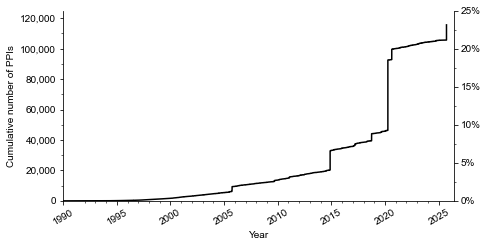

In [7]:
time_line_plot(df, 
               name='human', 
               ymax=125000, 
               y_tick_freq=20000,
               y_minor_tick_freq=10000)

INFO:fontTools.subset:maxp pruned
INFO:fontTools.subset:LTSH dropped
INFO:fontTools.subset:cmap pruned
INFO:fontTools.subset:kern dropped
INFO:fontTools.subset:post pruned
INFO:fontTools.subset:PCLT dropped
INFO:fontTools.subset:GPOS pruned
INFO:fontTools.subset:GSUB pruned
INFO:fontTools.subset:JSTF dropped
INFO:fontTools.subset:DSIG dropped
INFO:fontTools.subset:name pruned
INFO:fontTools.subset:glyf pruned
INFO:fontTools.subset:Added gid0 to subset
INFO:fontTools.subset:Added first four glyphs to subset
INFO:fontTools.subset:Closing glyph list over 'GSUB': 32 glyphs before
INFO:fontTools.subset:Glyph names: ['.notdef', '.null', 'C', 'I', 'P', 'Y', 'a', 'b', 'comma', 'e', 'eight', 'f', 'five', 'four', 'i', 'l', 'm', 'n', 'nine', 'nonmarkingreturn', 'o', 'one', 'percent', 'r', 's', 'six', 'space', 't', 'two', 'u', 'v', 'zero']
INFO:fontTools.subset:Glyph IDs:   [0, 1, 2, 3, 8, 15, 19, 20, 21, 23, 24, 25, 27, 28, 38, 44, 51, 60, 68, 69, 72, 73, 76, 79, 80, 81, 82, 85, 86, 87, 88, 89]
I

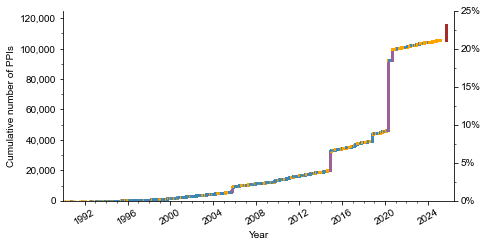

In [8]:
time_line_plot_colored(df, 
               name='human', 
               ymax=125000, 
               y_tick_freq=20000,
               y_minor_tick_freq=10000)

bump after Luck et al.

2020-08-18

PMID: 32814053 

6,696 PPIs

Interactome Mapping Provides a Network of Neurodegenerative Disease Proteins and Uncovers Widespread Protein Aggregation in Affected Brains
terms: two hybrid array, two hybrid pooling approach, validated two hybri


3 bumps between Rolland et al. and Luck et al.

2018-10-01

4,550 PPIs

PMID: 30021884

terms: proximity labelling technology, cross-linking study


Histone Interaction Landscapes Visualized by Crosslinking Mass Spectrometry in Intact Cell Nucle
2017-12-27  

1,948 PPIs

PMID: 29128334


A Map of Human Mitochondrial Protein Interactions Linked to Neurodegeneration Reveals New Mechanisms of Redox Homeostasis and NF-κB Signaling
terms: cross-linking study, affinity chromatography technolog

2017-03-15 

976 PPIs 

PMID: 28298427

Systematic protein-protein interaction mapping for clinically relevant human GPCRs

terms: two hybrid, ubiquitin reconstruction